# Fitting Linear Models with Custom Loss Functions and Regularization in Python

### by [Alex P. Miller](https://alex.miller.im/) ([@alexpmil](https://twitter.com/alexpmil))

As part of a predictive model competition I participated in earlier this month, I found myself trying to accomplish a peculiar task. The challenge organizers were going to use "mean absolute percentage error" (MAPE) as their criterion for model evaluation. Since this is not a standard loss function built into most software, I decided to write my own code to train a model that would use the MAPE in its objective function. 

I started by searching through the SciKit-Learn documentation on [linear models](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) to see if the model I needed has already been developed somewhere. I thought that the `sklearn.linear_model.RidgeCV` class would accomplish what I wanted (MAPE minimization with L2 regularization), but I could not get the `scoring` argument (which supposedly lets you pass a custom loss function to the model class) to behave as I expected it to.

While I highly recommend searching through existing packages to see if the model you want already exists, you should (in theory) be able to use this notebook as a template for a building linear models with an arbitrary loss function and regularization scheme.

## Python Code

I'll be using a Jupyter Notebook (running Python 3) to build my model. If you're reading this on my website, you can find [the raw .ipynb file linked here](https://github.com/alexmill/website_notebooks/blob/master/custom-loss-function-regularization-python.ipynb); you can also run a fully-exectuable version of the notebook the the Binder platform by [clicking here](https://mybinder.org/v2/gh/alexmill/website_notebooks/master?filepath=custom-loss-function-regularization-python.ipynb).

We'll start with some basic imports:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

## Load Your Data

For the purposes of this walkthrough, I'll need to generate some raw data. Presumably, if you've found yourself here, you will want to substitute this step with one where you load your own data. 

I am simulating a scenario where I have 100 observations on 10 features (9 features and an intercept). The "true" function will simply be a linear function of these features: $y=X\beta$. However, we want to simulate observing these data with noise. Because I'm mostly going to be focusing on the "mean absolute percentage error" loss function, I want my noise to be on an exponential scale, which is why I am taking exponents/logs below:

$$y = e^{log(X\beta) + \varepsilon}, \; \varepsilon \sim \mathcal{N}(0, 0.2)$$

In [2]:
# Generate predictors
X_raw = np.random.random(100*9)
X_raw = np.reshape(X_raw, (100, 9))

# Standardize the predictors
scaler = StandardScaler().fit(X_raw)
X = scaler.transform(X_raw)

# Add an intercept column to the model.
X = np.abs(np.concatenate((np.ones((X.shape[0],1)), X), axis=1))

# Define my "true" beta coefficients
beta = np.array([2,6,7,3,5,7,1,2,2,8])

# Y = Xb
Y_true = np.matmul(X,beta)

# Observed data with noise
Y = Y_true*np.exp(np.random.normal(loc=0.0, scale=0.2, size=100))

## Define your custom loss function

I am mainly going to focus on the MAPE loss function in this notebook, but this is where you would substitute in your own loss function (if applicable). MAPE is defined as follows:

### Mean Absolute Percentage Error (MAPE)

$$ \text{error}(\beta) = \frac{100}{n} \sum_{i=1}^{n}\left| \frac{y_i - X_i\beta}{y_i} \right|$$

While I won't go to into too much detail here, I ended up using a *weighted* MAPE criteria to fit the model I used in the data science competition. Given a set of sample weights $w_i$, you can define the weighted MAPE loss function using the following formula:

### Weighted MAPE

$$\text{error}(\beta) =  100 \left( \sum_{i=1}^N w_i \right)^{-1} \sum_{i=1}^N w_i \left| \frac{y_i - X_i\beta}{y_i} \right|$$

In Python, the MAPE can be calculated with the function below:

In [3]:
def mean_absolute_percentage_error(y_pred, y_true, sample_weights=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    if np.any(y_true==0):
        print("Found zeroes in y_true. MAPE undefined. Removing from set...")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        if type(sample_weights) != type(None):
            sample_weights = np.array(sample_weights)
            sample_weights = np.delete(sample_weights, idx)
        
    if type(sample_weights) == type(None):
        return(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    else:
        sample_weights = np.array(sample_weights)
        assert len(sample_weights) == len(y_true)
        return(100/sum(sample_weights)*np.dot(
                sample_weights, (np.abs((y_true - y_pred) / y_true))
        ))
    
loss_function = mean_absolute_percentage_error

## Fitting a simple linear model with custom loss function

You may know that the traditional method for fitting linear models, ordinary least squares, has a nice analytic solution. This means that the "optimal" model parameters that minimize the squared error of the model, can be calculated directly from the input data:

$$ \hat\beta = \arg\min_\beta \frac{1}{n} \sum_{i=1}^n (y_i - X_i\beta)^2 =  (X^\mathrm{T}X)^{-1}X^\mathrm{T}y $$

However, with an arbitrary loss function, there is no guarantee that finding the optimal parameters can be done so easily. To keep this notebook as generalizable as possible, I'm going to be minimizing our custom loss functions using numerical optimization techniques (similar to the "solver" functionality in Excel). In general terms, the $\beta$ we want to fit can be found as the solution to the following equation (where I've subsituted in the MAPE for the error function in the last line):

$$ \hat\beta = \arg\min_\beta \; \text{error}(\beta) = \arg\min_\beta \frac{100}{n} \sum_{i=1}^{n}\left| \frac{y_i - X_i\beta}{y_i} \right| $$

Essentially we want to search over the space of all $\beta$ values and find the value that minimizes our chosen error function. To get a flavor for what this looks like in Python, I'll fit a simple MAPE model below, using the `minimize` function from SciPy. 

In [6]:
from scipy.optimize import minimize

def objective_function(beta, X, Y):
    error = loss_function(np.matmul(X,beta), Y)
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
beta_init = np.array([1]*X.shape[1])
result = minimize(objective_function, beta_init, args=(X,Y),
                  method='BFGS', options={'maxiter': 500})

# The optimal values for the input parameters are stored
# in result.x
beta_hat = result.x
print(beta_hat)

[ 9.08252394  5.54995839  8.75233095  1.1883712   3.29482497  5.03886496
 -0.22556182  0.38830739  3.15524308  5.24599191]


We can compare the esimated betas to the true model betas that we initialized at the beginning of this notebook:

In [7]:
pd.DataFrame({
    "true_beta": beta, 
    "estimated_beta": beta_hat,
    "error": beta-beta_hat
})[["true_beta", "estimated_beta", "error"]]

,true_beta,estimated_beta,error
0,2,9.082524,-7.082524
1,6,5.549958,0.450042
2,7,8.752331,-1.752331
3,3,1.188371,1.811629
4,5,3.294825,1.705175
5,7,5.038865,1.961135
6,1,-0.225562,1.225562
7,2,0.388307,1.611693
8,2,3.155243,-1.155243
9,8,5.245992,2.754008


It's obviously not perfect, but we can see that our estimated values are at least in the ballpark from the true values. We can also calculate the final MAPE of our estimated model using our loss function:

In [8]:
loss_function(np.matmul(X,beta_hat), Y)

14.354033248368872

## Incorporating Regularization into Model Fitting

The process described above fits a simple linear model to the data provided by directly minimizing the a custom loss function (MAPE, in this case). However, in many machine learning problems, you will want to [regularize](https://en.wikipedia.org/wiki/Regularization_(mathematics)) your model parameters to prevent overfitting. In this notebook, I'm going to walk through the process of incorporating L2 regularization, which amounts to penalizing your model's parameters by the square of their magnitude. 

In precise terms, rather than minimizing our loss function directly, we will augment our loss function by adding a squared penalty term on our model's coefficients. With L2 regularization, our new loss function becomes:

$$ L(\beta) = \frac{100}{N} \sum_{i=1}^N \left| \frac{y_i - X_i\beta}{y_i} \right| + \lambda \sum_{k=1}^K \beta_k^2 $$

Or, in the case that sample weights are provided:

$$ L(\beta) = 100 \left( \sum_{i=1}^N w_i \right)^{-1} \sum_{i=1}^N w_i \left| \frac{y_i - X_i\beta}{y_i} \right| + \lambda \sum_{k=1}^K \beta_k^2 $$

For now, we will assume that the $\lambda$ coefficient (the regularization parameter) is already known. However, later we will use cross validation to find the optimal $\lambda$ value for our data.


Since our  model is getting a little more complicated, I'm going to define a Python class with a very similar attribute and method scheme as those found in SciKit-Learn (e.g., `sklearn.linear_model.Lasso` or `sklearn.ensemble.RandomForestRegressor`).

In [9]:
class CustomLinearModel:
    """
    Linear model: Y = XB, fit by minimizing the provided loss_function
    with L2 regularization
    """
    def __init__(self, loss_function=mean_absolute_percentage_error, 
                 X=None, Y=None, sample_weights=None, beta_init=None, 
                 regularization=0.00012):
        self.regularization = regularization
        self.beta = None
        self.loss_function = loss_function
        self.sample_weights = sample_weights
        self.beta_init = beta_init
        
        self.X = X
        self.Y = Y
            
    
    def predict(self, X):
        prediction = np.matmul(X, self.beta)
        return(prediction)

    def model_error(self):
        error = self.loss_function(
            self.predict(self.X), self.Y, sample_weights=self.sample_weights
        )
        return(error)
    
    def l2_regularized_loss(self, beta):
        self.beta = beta
        return(self.model_error() + \
               sum(self.regularization*np.array(self.beta)**2))
    
    def fit(self, maxiter=250):        
        # Initialize beta estimates (you may need to normalize
        # your data and choose smarter initialization values
        # depending on the shape of your loss function)
        if type(self.beta_init)==type(None):
            # set beta_init = 1 for every feature
            self.beta_init = np.array([1]*self.X.shape[1])
        else: 
            # Use provided initial values
            pass
            
        if self.beta!=None and all(self.beta_init == self.beta):
            print("Model already fit once; continuing fit with more itrations.")
            
        res = minimize(self.l2_regularized_loss, self.beta_init,
                       method='BFGS', options={'maxiter': 500})
        self.beta = res.x
        self.beta_init = self.beta

In [10]:
l2_mape_model = CustomLinearModel(
    loss_function=mean_absolute_percentage_error,
    X=X, Y=Y, regularization=0.00012
)
l2_mape_model.fit()
l2_mape_model.beta

array([ 8.70454035,  5.56955027,  8.82671937,  1.10660836,  3.36271348,
        5.16710648, -0.08675964,  0.4776243 ,  3.12646051,  5.28643399])

Just to confirm that our regularization did work, let's make sure that the estimated betas found with regularization are different from those found without regularization (which we calculated earlier):

In [11]:
pd.DataFrame({
    "true_beta": beta, 
    "estimated_beta": beta_hat,
    "regularized_beta": l2_mape_model.beta
})[["true_beta", "estimated_beta", "regularized_beta"]]

,true_beta,estimated_beta,regularized_beta
0,2,9.082524,8.704540
1,6,5.549958,5.569550
2,7,8.752331,8.826719
3,3,1.188371,1.106608
4,5,3.294825,3.362713
5,7,5.038865,5.167106
6,1,-0.225562,-0.086760
7,2,0.388307,0.477624
8,2,3.155243,3.126461
9,8,5.245992,5.286434


Since our regularization parameter is so small, we can see that it didn't affect our coefficient estimates dramatically. But the fact that the betas are different between the two models indicates that our regularization does seem to be working.

Just to make sure things are in the realm of common sense, it's never a bad idea to plot your predicted Y against our observed Y.

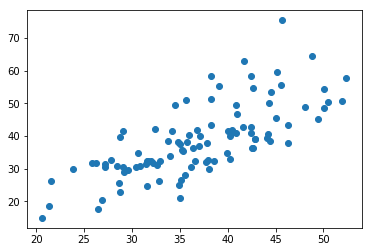

In [12]:
# Predicted Y vs. observed Y
plt.scatter(l2_mape_model.predict(X), Y)

## Important Caveat: Standardize Your Predictors
> In most applications, your features will be measured on many different scales; however you'll notice in the loss function described above, each $\beta_k$ parameter is being penalized by the same amount ($\lambda$). Best practice when using L2 regularization is to **standardize your feature matrix** (subtract the mean off of each column and divide the result by the column standard deviation). This will ensure that all features are on approximately the same scale and that the regularization parameter has an equal impact on all $\beta_k$ coefficients.

> I standardized my data at the very beginning of this notebook, but typically you will need to work standardization into your data pipeline. Use `sklearn.preprocessing.StandardScaler` and keep track of your intercept when going through this process!

## Cross Validation to Identify Optimal Regularization Parameter

At this point, we have a model class that will find the optimal beta coefficients to minimize the loss function described above with a given regularization parameter. Of course, your regularization parameter $\lambda$ will not typically fall from the sky. Below I've included some code that uses cross validation to find the optimal $\lambda$, among the set of candidates provided by the user.

In [13]:
from sklearn.model_selection import KFold

# Used to cross-validate models and identify optimal lambda
class CustomCrossValidator:
    
    """
    Cross validates arbitrary model using MAPE criterion on
    list of lambdas.
    """
    def __init__(self, X, Y, ModelClass,
                 sample_weights=None,
                 loss_function=mean_absolute_percentage_error):
        
        self.X = X
        self.Y = Y
        self.ModelClass = ModelClass
        self.loss_function = loss_function
        self.sample_weights = sample_weights
    
    def cross_validate(self, lambdas, num_folds=10):
        """
        lambdas: set of regularization parameters to try
        num_folds: number of folds to cross-validate against
        """
        
        self.lambdas = lambdas
        self.cv_scores = []
        X = self.X
        Y = self.Y 
        
        # Beta values are not likely to differ dramatically
        # between differnt folds. Keeping track of the estimated
        # beta coefficients and passing them as starting values
        # to the .fit() operator on our model class can significantly
        # lower the time it takes for the minimize() function to run
        beta_init = None
        
        for lam in self.lambdas:
            print("Lambda: {}".format(lam))
            
            # Split data into training/holdout sets
            kf = KFold(n_splits=num_folds, shuffle=True)
            kf.get_n_splits(X)
            
            # Keep track of the error for each holdout fold
            k_fold_scores = []
            
            # Iterate over folds, using k-1 folds for training
            # and the k-th fold for validation
            f = 1
            for train_index, test_index in kf.split(X):
                # Training data
                CV_X = X[train_index,:]
                CV_Y = Y[train_index]
                CV_weights = None
                if type(self.sample_weights) != type(None):
                    CV_weights = self.sample_weights[train_index]
                
                # Holdout data
                holdout_X = X[test_index,:]
                holdout_Y = Y[test_index]
                holdout_weights = None
                if type(self.sample_weights) != type(None):
                    holdout_weights = self.sample_weights[test_index]
                
                # Fit model to training sample
                lambda_fold_model = self.ModelClass(
                    regularization=lam,
                    X=CV_X,
                    Y=CV_Y,
                    sample_weights=CV_weights,
                    beta_init=beta_init,
                    loss_function=self.loss_function
                )
                lambda_fold_model.fit()
                
                # Extract beta values to pass as beta_init 
                # to speed up estimation of the next fold
                beta_init = lambda_fold_model.beta
                
                # Calculate holdout error
                fold_preds = lambda_fold_model.predict(holdout_X)
                fold_mape = mean_absolute_percentage_error(
                    holdout_Y, fold_preds, sample_weights=holdout_weights
                )
                k_fold_scores.append(fold_mape)
                print("Fold: {}. Error: {}".format( f, fold_mape))
                f += 1
            
            # Error associated with each lambda is the average
            # of the errors across the k folds
            lambda_scores = np.mean(k_fold_scores)
            print("LAMBDA AVERAGE: {}".format(lambda_scores))
            self.cv_scores.append(lambda_scores)
        
        # Optimal lambda is that which minimizes the cross-validation error
        self.lambda_star_index = np.argmin(self.cv_scores)
        self.lambda_star = self.lambdas[self.lambda_star_index]
        print("\n\n**OPTIMAL LAMBDA: {}**".format(self.lambda_star))

In [18]:
# User must specify lambdas over which to search
lambdas = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

cross_validator = CustomCrossValidator(
    X, Y, CustomLinearModel,
    loss_function=mean_absolute_percentage_error
)
cross_validator.cross_validate(lambdas, num_folds=5)

Lambda: 1
Fold: 1. Error: 281.675016261853
Fold: 2. Error: 288.38164186977633
Fold: 3. Error: 252.80554916202297
Fold: 4. Error: 274.83039775112576
Fold: 5. Error: 249.91013817877382
LAMBDA AVERAGE: 269.5205486447104
Lambda: 0.1
Fold: 1. Error: 21.494107244928493
Fold: 2. Error: 20.40295905215266
Fold: 3. Error: 18.66240844943417
Fold: 4. Error: 25.116437906551965
Fold: 5. Error: 22.90006062583064
LAMBDA AVERAGE: 21.715194655779584
Lambda: 0.01
Fold: 1. Error: 17.89961806856108
Fold: 2. Error: 20.60101543589219
Fold: 3. Error: 15.300577288722952
Fold: 4. Error: 16.103828700399553
Fold: 5. Error: 24.36922875047351
LAMBDA AVERAGE: 18.854853648809858
Lambda: 0.001
Fold: 1. Error: 22.120515998293445
Fold: 2. Error: 12.805498902418814
Fold: 3. Error: 17.399272285579485
Fold: 4. Error: 18.907906539945323
Fold: 5. Error: 15.496265314676894
LAMBDA AVERAGE: 17.34589180818279
Lambda: 0.0001
Fold: 1. Error: 18.90513051308685
Fold: 2. Error: 17.138574318436756
Fold: 3. Error: 24.855574956251054
Fo

After identifying the optimal $\lambda$ for your model/dataset, you will want to fit your final model using this value on the entire training dataset.

In [19]:
lambda_star = cross_validator.lambda_star
final_model = CustomLinearModel(
    loss_function=mean_absolute_percentage_error,
    X=X, Y=Y, regularization=lambda_star
)
final_model.fit()
final_model.beta

array([7.75056473, 5.66556818, 8.82981011, 1.08610394, 3.58484621,
       5.52614915, 0.21737665, 0.63868509, 3.04998495, 5.39175218])

You can then generate out-of-sample predictions using this final, fully optimized model.

In [20]:
test_data = np.random.random((10,10))
final_model.predict(test_data)

array([23.28912996, 30.44766829, 32.25209686, 25.3555125 , 21.03657229,
       16.94769912, 20.11264239, 28.44548273, 20.53333071, 28.27208959])